https://simdkalman.readthedocs.io/en/latest/

https://github.com/oseiskar/simdkalman

This can be up to 100x faster than pykalman and 70x faster than filterpy when can be vectorized over many independent timeseries. Also in the non-vectorized case, it can be 2x faster.

In [1]:
import simdkalman
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
%matplotlib inline

In [2]:
NOISE = 0.5

In [3]:
kf = simdkalman.KalmanFilter(
    state_transition = 1.0,
    process_noise = 0.1,
    observation_model = 1.0,
    observation_noise = 1.0)

In [4]:
%%time

x = np.linspace(0,2*np.pi,100)
data = np.sin(x) + np.random.random(100) * NOISE

kf = kf.em(data, n_iter=10)

# smooth and explain existing data
smoothed = kf.smooth(data)
# predict new data
pred = kf.predict(data, 15)

CPU times: user 239 ms, sys: 4.09 ms, total: 243 ms
Wall time: 241 ms


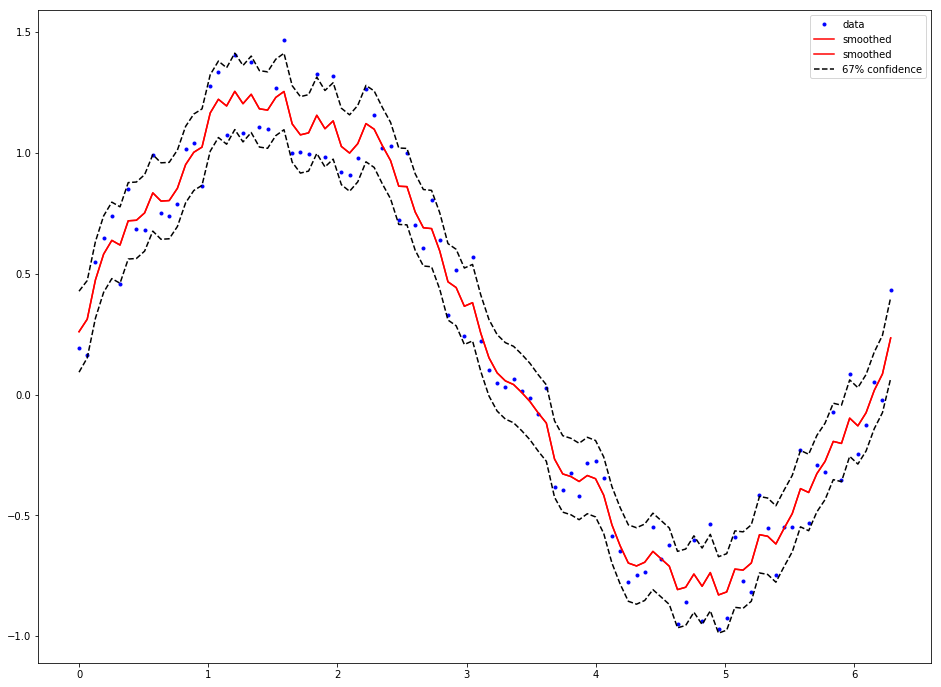

In [5]:
smoothed_obs = smoothed.states.mean[:,0]
obs_stdev = np.sqrt(smoothed.observations.cov)

plt.figure(figsize=(16,12))
plt.plot(x, data, 'b.', label="data")
plt.plot(x, smoothed_obs, 'r-', label="smoothed")
plt.plot(x, smoothed_obs, 'r-', label="smoothed")
plt.plot(x, smoothed_obs - obs_stdev, 'k--', label="67% confidence")
plt.plot(x, smoothed_obs + obs_stdev, 'k--')
plt.legend();

# Official example.py

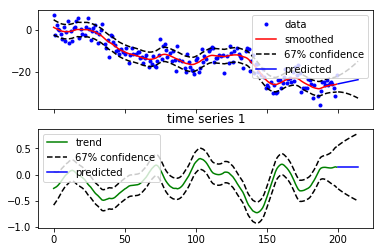

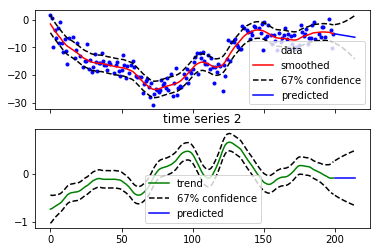

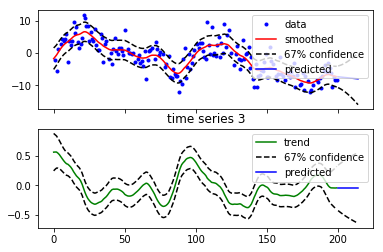

In [6]:
kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)

# simulate 100 random walk time series
rand = lambda: random.normal(size=(100, 200))
data = np.cumsum(np.cumsum(rand()*0.02, axis=1) + rand(), axis=1) + rand()*3

# introduce 10% of NaNs denoting missing values
data[random.uniform(size=data.shape) < 0.1] = np.nan

# fit noise parameters to data with the EM algorithm (optional)
kf = kf.em(data, n_iter=10)

# smooth and explain existing data
smoothed = kf.smooth(data)
# predict new data
pred = kf.predict(data, 15)
# could be also written as
# r = kf.compute(data, 15); smoothed = r.smoothed; pred = r.predicted

import matplotlib.pyplot as plt

# show the first 3 smoothed time series
for i in range(3):

    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.title("time series %d" % (i+1))

    x = np.arange(0, data.shape[1])

    ax1.plot(x, data[i,:], 'b.', label="data")

    smoothed_obs = smoothed.observations.mean[i,:]
    obs_stdev = np.sqrt(smoothed.observations.cov[i,:])
    ax1.plot(x, smoothed_obs, 'r-', label="smoothed")
    ax1.plot(x, smoothed_obs - obs_stdev, 'k--', label="67% confidence")
    ax1.plot(x, smoothed_obs + obs_stdev, 'k--')

    x_pred = np.arange(data.shape[1], data.shape[1]+pred.observations.mean.shape[1])
    y_pred = pred.observations.mean[i,:]
    pred_stdev = np.sqrt(pred.observations.cov[i,:])
    ax1.plot(x_pred, y_pred, 'b-', label="predicted")
    ax1.plot(x_pred, y_pred + pred_stdev, 'k--')
    ax1.plot(x_pred, y_pred - pred_stdev, 'k--')
    ax1.legend()

    trend = smoothed.states.mean[i,:,1]
    trend_stdev = np.sqrt(smoothed.states.cov[i,:,1,1])
    ax2.plot(x, trend, 'g-', label="trend")
    ax2.plot(x, trend - trend_stdev, 'k--', label="67% confidence")
    ax2.plot(x, trend + trend_stdev, 'k--')

    trend_pred = pred.states.mean[i,:,1]
    trend_pred_stdev = np.sqrt(pred.states.cov[i,:,1,1])
    ax2.plot(x_pred, trend_pred, 'b-', label='predicted')
    ax2.plot(x_pred, trend_pred + trend_pred_stdev, 'k--')
    ax2.plot(x_pred, trend_pred - trend_pred_stdev, 'k--')
    ax2.legend()

    plt.show()